## Notebook to benchmark VAE-based gene perturbation classification against linear and simple dl models

### Read Perturb-seq dataset

In [1]:
import os
os.chdir('../')
import logging
import numpy as np
logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
%load_ext autoreload
%autoreload 2

### Set parameters

In [42]:
# Set all labels and parameters
cls_label = 'perturbation'
scanvi_cls = 'celltype'
cls_labels = ['celltype', 'perturbation_type', 'perturbation']
unknown_label = 'unknown'
batch_label = 'dataset'
min_cells = 50
seed = 42

### Load or cache dataset

#### Load

In [3]:
import scanpy as sc
# load meta-set
adata_path = 'data/use_raw:True;min_cells:all;n_samples:50;n_perts:100;log1p:False;scale:False.h5ad'
src_adata = sc.read(adata_path)

2025-03-04 14:38:43,004 - INFO - Note: NumExpr detected 52 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureW

#### Subset dataset

In [6]:
N = 100
idx = np.where(src_adata.obs[cls_labels[-1]].isin(src_adata.obs[cls_labels[-1]].value_counts()[:N].index))[0]
src_adata._inplace_subset_obs(idx)

In [7]:
src_adata.write_h5ad('data/use_raw:True;min_cells:all;n_samples:50;n_perts:100;log1p:False;scale:False.h5ad')

In [4]:
src_adata.obs.cancer.value_counts()

cancer
True    171633
Name: count, dtype: int64

In [24]:
src_adata.obs.dataset.value_counts()

dataset
ReplogleWeissman2022_K562_gwps         126281
ReplogleWeissman2022_rpe1               45632
ReplogleWeissman2022_K562_essential     41165
Name: count, dtype: int64

#### Select dataset(s) to use

In [25]:
# Focus on one dataset
adata = src_adata[src_adata.obs.dataset=='ReplogleWeissman2022_K562_essential'].copy()

In [26]:
adata

AnnData object with n_obs × n_vars = 41165 × 15639
    obs: 'perturbation', 'tissue_type', 'cancer', 'celltype', 'disease', 'organism', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'dataset', 'perturbation_type', 'exact_perturbation'

#### Cache

In [4]:
import scanpy as sc
src_adata = sc.read('benchmark/rpe_pp.h5ad')

2025-03-01 14:03:28,556 - INFO - Note: NumExpr detected 52 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureW

### Pre-process data (skip when using cached adata)

In [27]:
# transform to csr matrix
import scipy.sparse as sp
adata.X = sp.csr_matrix(adata.X)

#### Do quality control on cells

In [8]:
from src.preprocess import quality_control_filter

quality_control_filter(adata, percent_threshold=20, nmads=5, mt_nmads=3, mt_per=10, inplace=False)

In [9]:
qc_mask = (~adata.obs.outlier) & (~adata.obs.mt_outlier)
logging.info(f'QC filtering: {np.sum(qc_mask)}/{adata.n_obs}')

2025-03-03 12:21:22,560 - INFO - QC filtering: 47375/129003


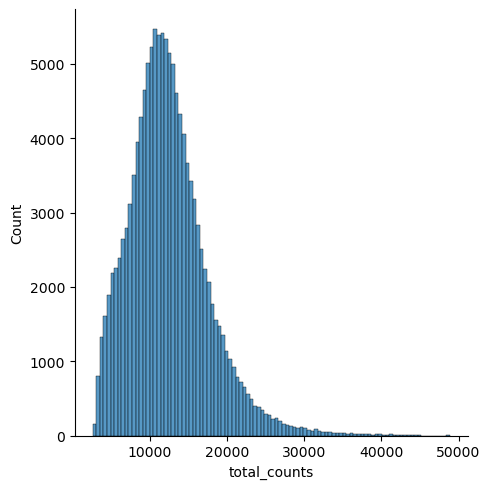

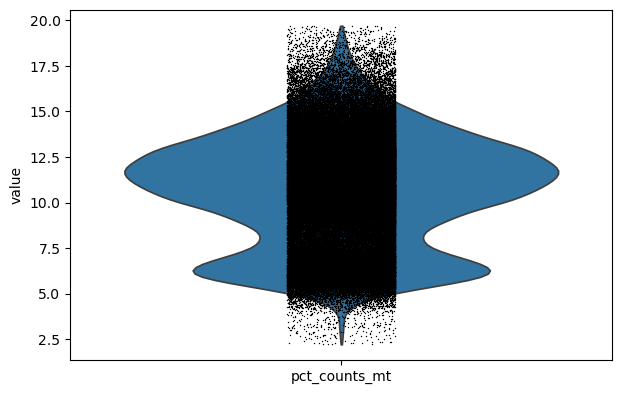

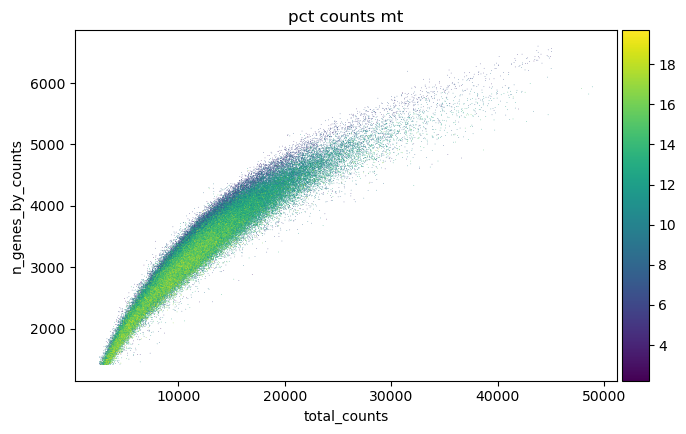

In [10]:
import seaborn as sns
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [27]:
adata._inplace_subset_obs(qc_mask)

#### Filter for minimum amount of cells per perturbation

In [28]:
N = 100
vp = adata.obs[cls_label].value_counts()[:N] >= min_cells
valid_perturbations = vp[vp].index.tolist()
total = adata.n_obs
adata = adata[adata.obs[cls_label].isin(valid_perturbations)].copy()
logging.info(f'Removed {total-adata.n_obs} cells with low confidence')

2025-02-28 16:40:00,205 - INFO - Removed 158134 cells with low confidence


In [29]:
# Total number of perturbations
n_perturbations = adata.obs[cls_label].nunique()
logging.info(f'Total number of perturbations: {n_perturbations}')

2025-02-28 16:40:03,072 - INFO - Total number of perturbations: 100


#### Check number of cells per perturbation

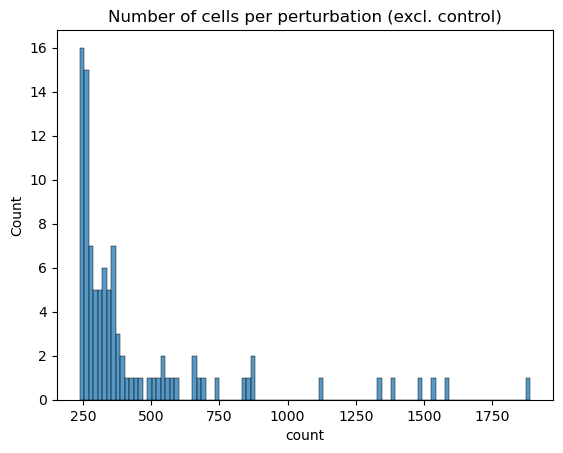

In [31]:
# check distribution of number of cells per perturbations
import matplotlib.pyplot as plt
import seaborn as sns
cpp = adata.obs[cls_label].value_counts()

ax = sns.histplot(cpp[cpp.index!='control'], bins=100, kde=False)
plt.title('Number of cells per perturbation (excl. control)')
plt.show()

#### Filter for highly variable genes

In [28]:
sc.pp.filter_genes(adata, min_counts=1)

In [29]:
if 'log1p' in adata.layers:
    logging.info('Detected log1p layer, deleting')
    del adata.layers['log1p']

In [30]:
adata.layers['log1p'] = sc.pp.normalize_total(                                  # normalize for total number of cells
    adata, target_sum=None, inplace=False
)['X']
sc.pp.log1p(adata, layer='log1p')                                               # normalize to log1p
d = adata.layers['log1p'].mean(axis=0)                                          # take mean gene expression per cell
d = np.squeeze(np.asarray(d))

In [31]:
min_mean = np.quantile(d, 0.25)                                                 # exclude low 25% quantile of mean expression
max_mean = np.quantile(d, 0.99)                                                 # exclude high 95% quantile
min_disp = 0.1                                                                  # default min dispersion
logging.info(f'Min. log1p mean threshold: {min_mean}')
logging.info(f'Max. log1p mean threshold: {max_mean}')
sc.pp.highly_variable_genes(                                                    # calculate highly variable genes based on parameters
    adata, layer='log1p',
    min_disp=min_disp, min_mean=min_mean, max_mean=max_mean
)
logging.info(f'HVGs: {np.sum(adata.var.highly_variable)}/{adata.n_vars}')

2025-03-04 15:20:46,859 - INFO - Min. log1p mean threshold: 0.14626924693584442
2025-03-04 15:20:46,860 - INFO - Max. log1p mean threshold: 3.2028865003585785
2025-03-04 15:20:48,631 - INFO - HVGs: 1698/8563


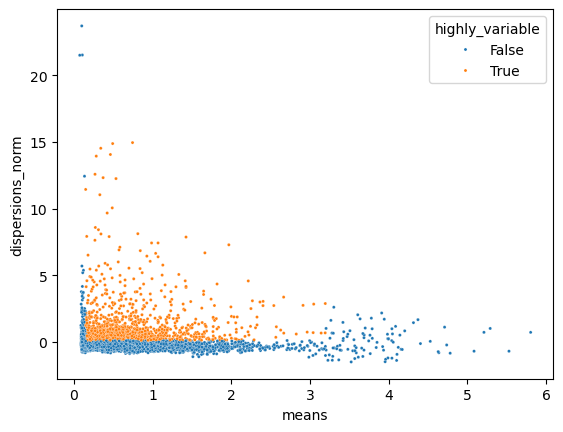

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.scatterplot(
    data=adata.var, x="means", y="dispersions_norm", hue="highly_variable", s=5
)

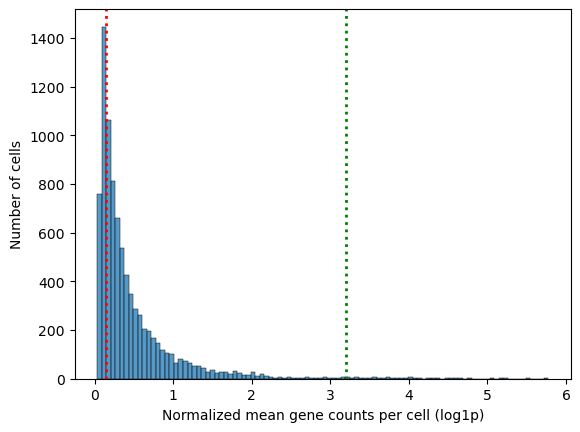

In [33]:
ax = sns.histplot(d, bins=100, kde=False)
ax.axvline(min_mean, color='red', linestyle='dotted', linewidth=2)
ax.axvline(max_mean, color='green', linestyle='dotted', linewidth=2)
plt.xlabel('Normalized mean gene counts per cell (log1p)')
plt.ylabel('Number of cells')
plt.show()

In [34]:
# subset adata to highly variable genes
adata._inplace_subset_var(adata.var.highly_variable)

### Remove controls?

In [35]:
# remove control group?
ctrl_mask = (adata.obs['perturbation']!='control')
adata = adata[ctrl_mask].copy()

In [36]:
n_perturbations = adata.obs[cls_label].nunique()
logging.info(f'Registered {n_perturbations} classes')

2025-03-04 15:21:04,430 - INFO - Registered 99 classes


#### save data for later use

In [51]:
adata.write_h5ad('benchmark/model_set.h5ad')

... storing 'initial_split' as categorical


### Compress adata

In [28]:
adata.X = adata.layers['log1p']

In [63]:
from src.sampling import CellCompressor

cell_compressor = CellCompressor(
    adata=adata, groups=['perturbation_type'], condition='perturbation', method='var', seed=seed
)

In [64]:
adata = cell_compressor(
    min_cells=200, min_conditions=10,
    n_samples=100, raw=False
).copy()

2025-03-01 17:15:05,675 - INFO - Found 99 shared conditions (out of 99) between 1 groups (out of 1)
2025-03-01 17:15:05,676 - INFO - Compressing dataset to 100 cells per condition and 100 for control groups
Compressing patient cells: 100%|██████████| 99/99 [00:01<00:00, 54.67condition/s]
2025-03-01 17:15:08,204 - INFO - Aggregating cells from each condition
2025-03-01 17:15:22,267 - INFO - Resulting dataset dimensions: (9900, 1595)


In [69]:
adata.layers['log1p'] = adata.X

### Use scanvi to harmonize datasets

#### scanVI parameters

In [67]:
import pytorch_lightning as pl
# set model dir
model_dir = 'benchmark/xgboost'
class_labels = adata.obs[scanvi_cls].unique()
n_labels = len(class_labels)-1 if 'unknown' in class_labels else len(class_labels)  
# set scale for kl divergence
klr = 1
cr = 1

# hyperparameters for model
cls_params = {
    'n_hidden': 128, 'n_layers': 1, 'dropout_rate': 0.1
}
scanvi_params = {
    'n_hidden': 128, 'n_latent': 20, 'n_layers': 1, 'dropout_rate': 0.1,
    'dispersion': 'gene',
    'use_batch_norm': 'both',
    'gene_likelihood': 'zinb',
    'use_class_weights': False,
    'linear_classifier': False,
    'classifier_parameters': cls_params,
    'use_posterior_mean': True
}

tensor_dir = os.path.join(model_dir, f'n_{n_labels}')

data_params = {
    'train_size': 0.9,
    'batch_size': 128,
    'num_workers': 1
}
plan_params = {
    'lr': 1e-3,
    'weight_decay': 1e-6,
    'kl_weight': klr,
    'classification_ratio': cr,
    'lr_scheduler_metric': 'validation_classification_loss'
}
train_params = {
    'max_epochs': 100,
    'early_stopping': False,
    'check_val_every_n_epoch': 1,
    'logger': pl.loggers.TensorBoardLogger(tensor_dir),
    'plan_kwargs': plan_params,
}

#### Train model

In [123]:
# train scvi for different latent dimensions and predict with xgboost on that
from src.benchmark import xgboost_scvi_latent_run

latent_dims = [10, 20, 30, 40, 50, 100, 200, 400, 600, 800, 1000]
latent_dims = [600]
acc_df, report = xgboost_scvi_latent_run(
    adata=adata,
    cls_label=cls_label,
    n_classes=n_perturbations,
    batch_label=batch_label,
    latent_dims=latent_dims
)

2025-03-04 22:36:13,463 - INFO - Running scvi w. 600 latent dimensions
2025-03-04 22:36:13,464 - INFO - Only one dataset, falling back to scvi
INFO: GPU available: True (cuda), used: True
2025-03-04 22:36:13,574 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-03-04 22:36:13,576 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-03-04 22:36:13,577 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-03-04 22:36:13,584 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-03-04 22:36:13,592 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
2025-03-04 22:40:29,496 - INFO - `Trainer.fit` stopped: `max_epochs=100` reached.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no 

In [131]:
# save run to file
acc_df.to_csv('benchmark/xgboost/n_1/acc.csv')
report.to_csv('benchmark/xgboost/n_1/report.csv')

In [134]:
acc_df = acc_df.reset_index(names='type')

In [161]:
acc_df_only = acc_df[acc_df.type=='accuracy'].copy()

In [179]:
acc_df_only.n_latent = pd.Categorical(acc_df_only.n_latent.astype(str), categories=acc_df_only.n_latent.sort_values().astype(str))

In [261]:
acc_df

,type,precision,recall,f1-score,support,n_latent
0,accuracy,0.102614,0.102614,0.102614,0.102614,10
1,macro avg,0.046244,0.063954,0.049681,3060.000000,10
2,weighted avg,0.068922,0.102614,0.077266,3060.000000,10
3,accuracy,0.122876,0.122876,0.122876,0.122876,20
4,macro avg,0.061229,0.079106,0.061181,3060.000000,20
5,weighted avg,0.082940,0.122876,0.090914,3060.000000,20
6,accuracy,0.131046,0.131046,0.131046,0.131046,30
7,macro avg,0.071434,0.085739,0.067814,3060.000000,30
8,weighted avg,0.090236,0.131046,0.098276,3060.000000,30
9,accuracy,0.142810,0.142810,0.142810,0.142810,40


In [200]:
# add xgboost on entire dataset
all_vars_report = pd.read_csv('benchmark/xgboost/wo_harmonization/1_ds/report.csv', index_col=0)
all_vars_report['n_latent'] = adata.n_vars
all_vars_report['method'] = 'XGBoost'
report['method'] = 'scvi + XGBoost'
report = pd.concat([report, all_vars_report], axis=0)

In [276]:
# add xgboost acc
xgbacc = pd.read_csv('benchmark/xgboost/wo_harmonization/1_ds/summary.csv', index_col=0).reset_index(names='type')
xgbacc['n_latent'] = adata.n_vars
acc_df['method'] = 'scvi + XGBoost'
xgbacc['method'] = 'XGBoost'
acc_df = pd.concat([acc_df, xgbacc], axis=0)

In [223]:
# add scanvi reports
scanvi_reports = pd.read_csv('benchmark/scanvi/report.csv', index_col=0)
scanvi_reports['method'] = 'custom scanvi'
scanvi_reports.drop(columns=['mode'], inplace=True)
report = pd.concat([report, scanvi_reports], axis=0)

In [224]:
# sort n_latent values
report.n_latent = report.n_latent.astype(int)
report.n_latent = pd.Categorical(report.n_latent.astype(str), categories=report.n_latent.sort_values().astype(str).unique())

In [241]:
report.method = pd.Categorical(report.method, categories=report.method.sort_values().unique())

In [297]:
report['weighted-f1-score'] = report['f1-score'] * (1 - report.support / report.support.sum())

In [299]:
report

,index,precision,recall,f1-score,support,perturbation,count,log_count,n_latent,method,weighted-f1-score
0,ABCF1,0.189189,0.212121,0.200000,33.0,ABCF1,33.0,3.496508,10,scvi + XGBoost,0.199882
1,GFM1,0.071429,0.035714,0.047619,28.0,GFM1,24.0,3.178054,10,scvi + XGBoost,0.047595
2,TACC3,0.000000,0.000000,0.000000,42.0,TACC3,13.0,2.564949,10,scvi + XGBoost,0.000000
3,MVK,0.084507,0.230769,0.123711,26.0,MVK,13.0,2.564949,10,scvi + XGBoost,0.123654
4,IK,0.000000,0.000000,0.000000,21.0,IK,28.0,3.332205,10,scvi + XGBoost,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
688,lymphoblasts;CRISPRi;WDR54,0.000000,0.000000,0.000000,15.0,NaN,NaN,NaN,100,custom scanvi,0.000000
689,lymphoblasts;CRISPRi;ZMAT2,0.358025,0.604167,0.449612,48.0,NaN,NaN,NaN,100,custom scanvi,0.449227
690,lymphoblasts;CRISPRi;ZNF207,0.000000,0.000000,0.000000,27.0,NaN,NaN,NaN,100,custom scanvi,0.000000
691,lymphoblasts;CRISPRi;ZNF574,0.000000,0.000000,0.000000,24.0,NaN,NaN,NaN,100,custom scanvi,0.000000


2025-03-05 00:51:50,380 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-05 00:51:50,385 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


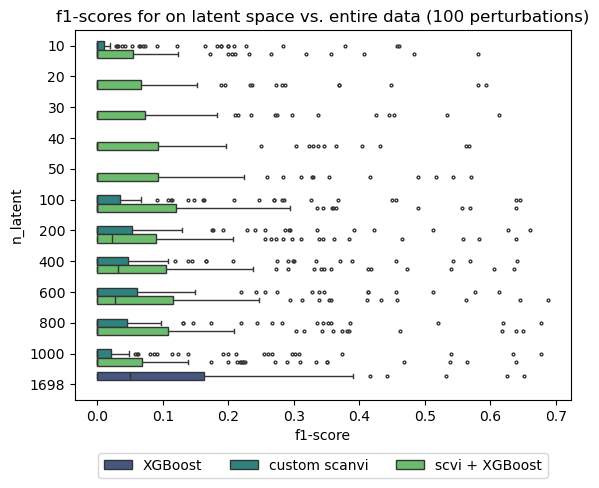

In [300]:
metric = 'f1-score'
mean_df = report.groupby('n_latent', observed=True)[metric].mean().reset_index()
means_per_method = report.groupby(['method', 'n_latent'], observed=True)[metric].mean().reset_index()
ax = sns.boxplot(report, y='n_latent', x=metric, hue='method', palette='viridis', zorder=1, fliersize=2)
#sns.scatterplot(mean_df, x='n_latent', y='f1-score', color='red', s=100, marker='X', label='Mean', ax=ax, zorder=10)
#sns.scatterplot(means_per_method, x='n_latent', y='f1-score', hue='method', palette='viridis', ax=ax, zorder=10)
plt.title(f'{metric}s for on latent space vs. entire data (100 perturbations)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), ncol=report.method.nunique())
plt.show()

In [285]:
acc_df.method = pd.Categorical(acc_df.method, categories=acc_df.method.sort_values().unique())
# sort n_latent values
acc_df.n_latent = acc_df.n_latent.astype(int)
acc_df.n_latent = pd.Categorical(acc_df.n_latent.astype(str), categories=acc_df.n_latent.sort_values().astype(str).unique())

In [306]:
2*((0.25 * 0.4)/(0.25 + 0.4))

0.3076923076923077

2025-03-05 01:49:44,602 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-05 01:49:44,606 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


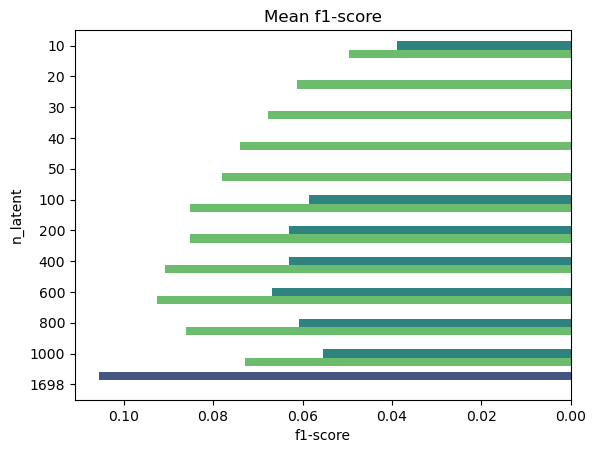

In [305]:
ax = sns.barplot(means_per_method, y='n_latent', x=metric, hue='method', palette='viridis', zorder=1, legend=False)
plt.xlabel(f'{metric}')
plt.title(f'Mean {metric}')
ax.invert_xaxis()

In [68]:
import scvi
# run scvi for less than two cell types
if n_labels < 2:
    logging.info(f'Only one dataset, falling back to scvi')
    scvi.model.SCVI.setup_anndata(
        adata, batch_key=batch_label
    )
    model = scvi.model.SCVI(adata, n_latent=scanvi_params['n_latent'])
    model.train(early_stopping=True)
else:
    logging.info(f'Running scanvi with {n_labels} labels')
    from src.train import prepare_scanvi
    scvi.model.SCANVI.setup_anndata(
        adata,
        labels_key=scanvi_cls,
        unlabeled_category=unknown_label,
        batch_key=batch_label
    )
    # same training parameters
    model = scvi.model.SCANVI(adata, **scanvi_params)
    # get runner and data splitter
    runner, data_splitter = prepare_scanvi(scanvae, data_params, train_params)
    logging.info(f'Running at: {tensor_dir}')
    runner()

2025-03-04 15:55:17,634 - INFO - Only one dataset, falling back to scvi
INFO: GPU available: True (cuda), used: True
2025-03-04 15:55:17,733 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-03-04 15:55:17,734 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-03-04 15:55:17,735 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-03-04 15:55:17,750 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-03-04 15:55:17,759 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to impro

Training:   0%|          | 0/261 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=261` reached.
2025-03-04 16:05:32,194 - INFO - `Trainer.fit` stopped: `max_epochs=261` reached.


In [ ]:
import pytorch_
# set model dir
model_dir = 'benchmark/xgboost'
class_labels = model_set.obs[scanvi_cls].unique()
n_labels = len(class_labels)-1 if 'unknown' in class_labels else len(class_labels)  
# set scale for kl divergence
klr = 1
cr = 1

# hyperparameters for model
cls_params = {
    'n_hidden': 128, 'n_layers': 1, 'dropout_rate': 0.05
}
scanvi_params = {
    'n_hidden': 128, 'n_latent': 10, 'n_layers': 1, 'dropout_rate': 0.05,
    'dispersion': 'gene',
    'use_batch_norm': 'both',
    'gene_likelihood': 'zinb',
    'use_class_weights': False,
    'linear_classifier': False,
    'classifier_parameters': cls_params,
    'use_posterior_mean': True
}

tensor_dir = os.path.join(model_dir, f'n_{n_labels}')

data_params = {
    'train_size': 0.9,
    'batch_size': 128,
    'num_workers': 1
}
plan_params = {
    'lr': 1e-5,
    'weight_decay': 1e-6,
    'kl_weight': klr,
    'classification_ratio': cr,
    'lr_scheduler_metric': 'validation_classification_loss'
}
train_params = {
    'max_epochs': 100,
    'early_stopping': False,
    'check_val_every_n_epoch': 1,
    'logger': pl.loggers.TensorBoardLogger(tensor_dir),
    'plan_kwargs': plan_params,
}

#### Split data into training and testing sets

In [96]:
from sklearn.model_selection import train_test_split

# get latent space from training
X = adata.layers['log1p']
y = adata.obs[cls_label]  # Class labels

# Perform stratified train-test split
train_idx, test_idx = train_test_split(
    range(adata.n_obs),
    test_size=0.1,
    stratify=y,           # Preserve class distribution
    random_state=seed
)
adata.obs['initial_split'] = None
adata.obs.iloc[train_idx, (adata.obs.shape[1]-1)] = 'train'
adata.obs.iloc[test_idx, (adata.obs.shape[1]-1)] = 'test'
# split the data before we start upsampling
train_set = adata[train_idx].copy()
test_set = adata[test_idx].copy()

### XGBoost

In [97]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

# Start with a basic model
xgb_clf = xgb.XGBClassifier(
    tree_method='hist',
    objective='multi:softprob',
    num_class=n_perturbations,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    reg_alpha=0.5,        # Increase L1 regularization
    reg_lambda=2.0,       # Increase L2 regularization
    min_child_weight=10,   # Require more observations per leaf
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=10,
)

In [98]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

# get actul training data
X_train, y_train = X[train_idx], y_encoded[train_idx]
X_test, y_test = X[test_idx], y_encoded[test_idx]

In [99]:
# Train the model
xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

[0]	validation_0-mlogloss:4.52602	validation_1-mlogloss:4.54282
[1]	validation_0-mlogloss:4.47235	validation_1-mlogloss:4.50496
[2]	validation_0-mlogloss:4.42544	validation_1-mlogloss:4.47391
[3]	validation_0-mlogloss:4.37933	validation_1-mlogloss:4.44306
[4]	validation_0-mlogloss:4.33835	validation_1-mlogloss:4.41581
[5]	validation_0-mlogloss:4.29791	validation_1-mlogloss:4.39133
[6]	validation_0-mlogloss:4.25960	validation_1-mlogloss:4.36772
[7]	validation_0-mlogloss:4.22330	validation_1-mlogloss:4.34765
[8]	validation_0-mlogloss:4.19083	validation_1-mlogloss:4.32995
[9]	validation_0-mlogloss:4.15935	validation_1-mlogloss:4.31144
[10]	validation_0-mlogloss:4.12987	validation_1-mlogloss:4.29567
[11]	validation_0-mlogloss:4.09907	validation_1-mlogloss:4.27919
[12]	validation_0-mlogloss:4.07074	validation_1-mlogloss:4.26456
[13]	validation_0-mlogloss:4.04312	validation_1-mlogloss:4.25085
[14]	validation_0-mlogloss:4.01653	validation_1-mlogloss:4.23792
[15]	validation_0-mlogloss:3.98962	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=10, num_class=99, num_parallel_tree=None, ...)

In [265]:
from src.performance import get_classification_report
# 4. Evaluate the model
y_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Detailed classification report
summary_xg, report_xg = get_classification_report(test_set, y_test, y_pred, cls_label)

Accuracy: 0.1827


/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [266]:
summary_xg

,precision,recall,f1-score,support
accuracy,0.182680,0.182680,0.182680,0.18268
macro avg,0.114224,0.132608,0.105594,3060.00000
weighted avg,0.138149,0.182680,0.139730,3060.00000


In [267]:
from src.plotting import get_latest_tensor_dir

version_dir = 'benchmark/xgboost/wo_harmonization/1_ds'
os.makedirs(version_dir, exist_ok=True)
xgb_clf.save_model(os.path.join(version_dir, 'model.json'))
report_xg.to_csv(os.path.join(version_dir, 'report.csv'))
summary_xg.to_csv(os.path.join(version_dir, 'summary.csv'))

In [105]:
report['mode'] = 'val'

In [112]:
report[report['f1-score']>0]['f1-score'].mean()

0.193589622749502

<Axes: xlabel='mode', ylabel='f1-score'>

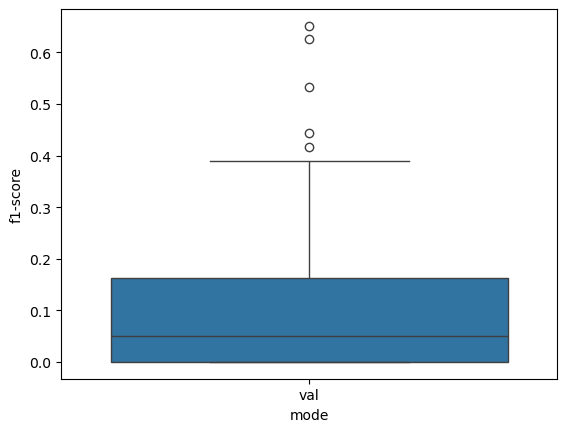

In [106]:
sns.boxplot(report, x='mode', y='f1-score')

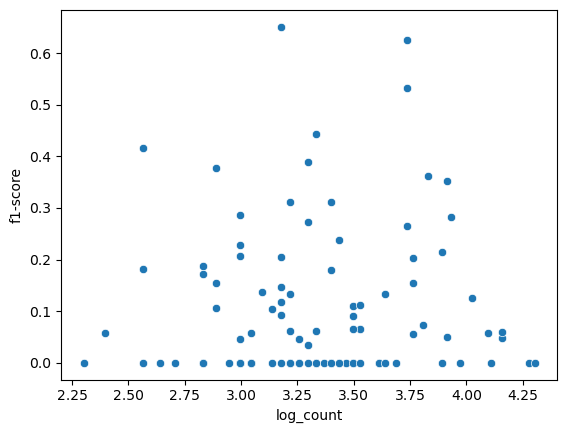

In [103]:
import seaborn as sns
ax = sns.scatterplot(report, x='log_count', y='f1-score')

### Run XGBoost on scanvi trained latent space and compare

In [79]:
mask = (report.recall >= 0.7) & (report.precision >= 0.7)

In [80]:
test_set.obs['pr'] = 'bad'
test_set.obs.loc[test_set.obs[cls_label].isin(report[mask]['index']),'pr'] = 'good'

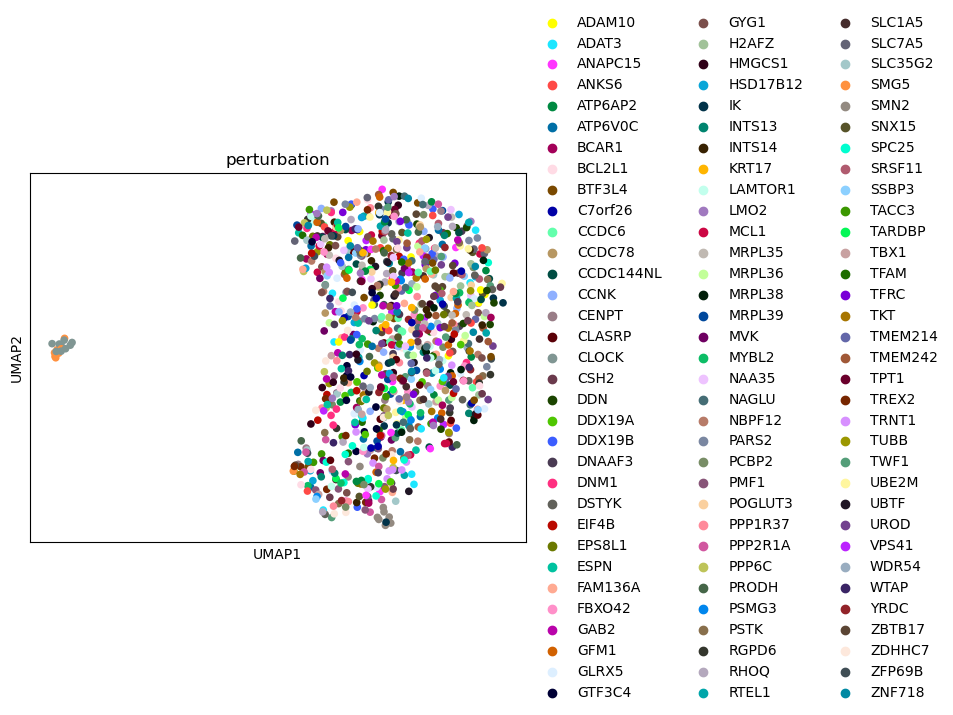

In [83]:
# --> ~35% acc on 100 gene-perturbations
test_set.obs['xgboost_pred'] = y_pred
# check umap results
sc.pp.pca(test_set)
sc.pp.neighbors(test_set)
sc.tl.umap(test_set)
sc.pl.umap(test_set, color=[cls_label])

In [86]:
test_set.obs['xgboost_pred'] = test_set.obs['xgboost_pred'].astype(str)

... storing 'xgboost_pred' as categorical


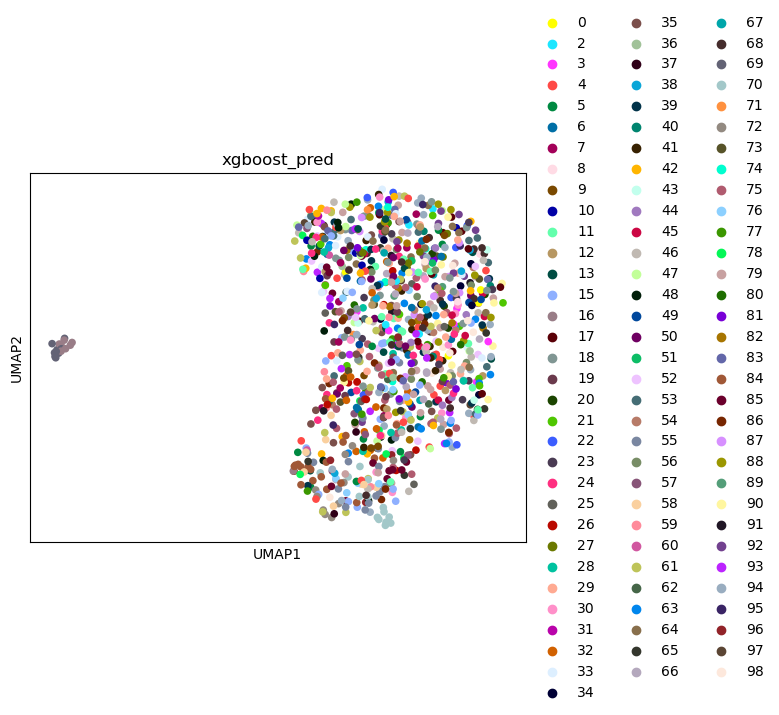

In [87]:
sc.pl.umap(test_set, color='xgboost_pred')

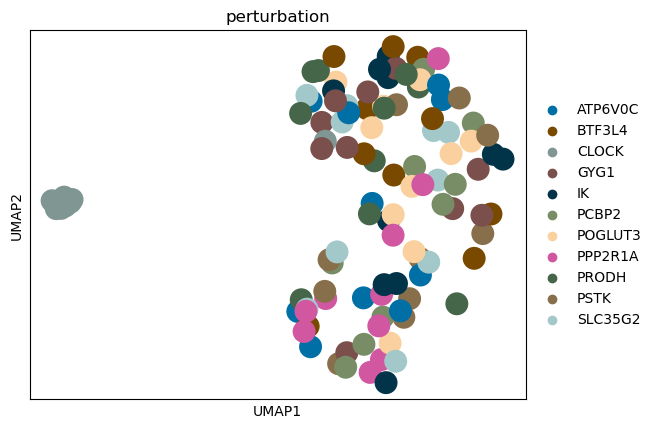

In [88]:
sc.pl.umap(test_set[test_set.obs['pr']=='good'], color=[cls_label])

### scanvi + xgboost

In [39]:
import scvi
scanvae = scvi.model.SCANVI(adata)

In [ ]:
scanvae.train()

### Linear classifier

In [46]:
from scvi.module._classifier import Classifier
import torch

lc = Classifier(
    n_input=adata.n_vars,         # number of genes
    n_labels=n_perturbations,     # number of perturbations
    n_layers=0,                   # use linear classifier
)

predictions = lc(torch.tensor(train_set.layers['log1p']))

In [56]:
classes = predictions.argmax(dim=-1)